SystemExit: 0

c:\Users\luisf\Documents\GitHub\Neuro_Engineering_Dev\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


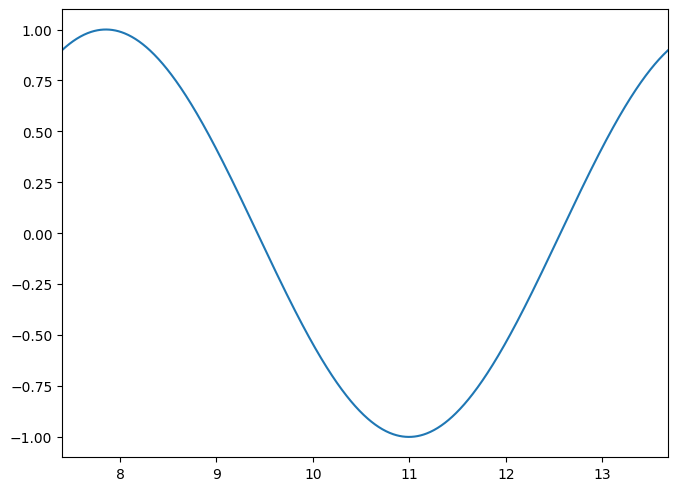

In [1]:
import sys
import numpy as np
from functions_openBCI import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtWidgets import QMainWindow, QApplication, QVBoxLayout, QWidget
from PyQt5 import QtCore

class PlotUpdater(QMainWindow):
    def __init__(self):
        # initialize the QMainwindow class object
        super().__init__()
        self.setWindowTitle("EEG electrodes")
        self.setGeometry(100, 100, 800, 600)

        #
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        #
        self.layout = QVBoxLayout()
        self.central_widget.setLayout(self.layout)

        #
        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvas(self.fig)
        self.layout.addWidget(self.canvas)

        # Generate the x,y coordinates to plot later on
        self.x = np.linspace(0, 2 * np.pi, 1000)
        self.y = np.sin(self.x)

        #initializes the plot, and intializes the self.line attribute, which is the function line itself 
        self.line, = self.ax.plot(self.x, self.y)
        # Initialize the timer attribute
        self.animation_timer = QtCore.QTimer(self)

        # THE FOLLOWING TWO LINES COMPRISE THE CORE LOOP OF THE CLASS TO KEEP UPDATING THE PLOT
        # Set a reaction for the flag of timeout for the attribute timer
        self.animation_timer.timeout.connect(self.update_plot)
        # Begin an arbitrary timer. Upon ending, it flags for timeout, returning to the previous line.
        self.animation_timer.start(50)  # Update plot every 50 milliseconds

    def update_plot(self):
        # Shift the sine wave to the right
        self.x += 0.1
        self.y = np.sin(self.x)

        # Update the data of the line plot
        self.line.set_xdata(self.x)
        self.line.set_ydata(self.y)

        # Adjust plot limits to keep the sine wave visible
        self.ax.set_xlim(self.x.min(), self.x.max())
        self.ax.set_ylim(-1.1, 1.1)

        # Redraw the plot
        self.canvas.draw()

    def make_board(self):
        btype = "other" # [cyton, other]
        self.cyton = open_board(btype)
    def grab_board(self):
        signal = self.cyton.get_board_data()

if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = PlotUpdater()
    window.show()
    sys.exit(app.exec_())

if  __name__ =="aaa":    

close_board(cyton)


In [2]:
close_board(cyton)


NameError: name 'cyton' is not defined